# Boston Crime Analysis


In this analysis I will be focusing on the analysis to deduce some predictions and trends in the crime stats.
I will be answering the Following questions:

    Q1. Which are the areas with high crime frequency?
    Q2. Time of the day having highest crime frequency.
    Q3. Is there any trend in the crime frequency?
    Q4. If yes, can predictions be made using this trend?
    Q5. Is it possible to forecast the daily frequency of crimes? How?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib import style
from ipyleaflet import *
import seaborn as sns; sns.set()

style.use('fivethirtyeight')
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

%matplotlib inline

In [62]:
from scipy.spatial import distance

In [2]:
df = pd.read_csv('crime.csv',encoding='latin-1')

# Dropping "INCIDENT_NUMBER"
df.drop("INCIDENT_NUMBER",axis=1, inplace=True)

#Separating 'Date' & 'Time' present in 'OCCURED_ON_DATE' coloumn
df[["DATE","TIME"]]=df['OCCURRED_ON_DATE'].str.split(" ",expand=True) 
df.drop("OCCURRED_ON_DATE", axis=1, inplace=True)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319073 entries, 0 to 319072
Data columns (total 17 columns):
OFFENSE_CODE           319073 non-null int64
OFFENSE_CODE_GROUP     319073 non-null object
OFFENSE_DESCRIPTION    319073 non-null object
DISTRICT               317308 non-null object
REPORTING_AREA         319073 non-null object
SHOOTING               1019 non-null object
YEAR                   319073 non-null int64
MONTH                  319073 non-null int64
DAY_OF_WEEK            319073 non-null object
HOUR                   319073 non-null int64
UCR_PART               318983 non-null object
STREET                 308202 non-null object
Lat                    299074 non-null float64
Long                   299074 non-null float64
Location               319073 non-null object
DATE                   319073 non-null object
TIME                   319073 non-null object
dtypes: float64(2), int64(4), object(11)
memory usage: 41.4+ MB
None


,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,DATE,TIME
0,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)",2018-09-02,13:00:00
1,1402,Vandalism,VANDALISM,C11,347,NaN,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)",2018-08-21,00:00:00
2,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)",2018-09-03,19:27:00
3,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)",2018-09-03,21:16:00
4,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)",2018-09-03,21:05:00


### Plotting Locations of Reported Crimeson the Map of Boston.

In [3]:
loc_df = pd.merge(df['Lat'],df['Long'],how='right', right_index=True, left_index=True)

loc_list=[]     #List of tuples/pairs of Lattitude and Longitude
for i, j in zip(loc_df['Lat'],loc_df['Long']):
    if math.isnan(i) or math.isnan(j): pass
    else:
        loc_list.append((i,j))

In [4]:
marker_list = [] #list of locations as marker for Map
for i in loc_list[:40]:
    marker_list.append(Marker(location=i))

m = Map(center=[42.3601,-71.0589], zoom=13)
marker_cluster = MarkerCluster(markers=tuple(marker_list))
m.add_layer(marker_cluster)
m

Map(center=[42.3601, -71.0589], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [5]:
f1 = df['Lat'].values
f1 = f1[~np.isnan(f1)]
f2 = df['Long'].values
f2 = f2[~np.isnan(f2)]
coordinates = np.array(list(zip(f1, f2)))

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=40)
kmeans = kmeans.fit(coordinates)
labels = kmeans.predict(coordinates)
centroids = kmeans.cluster_centers_

In [21]:
print(len(kmeans.labels_))

299074


The above pairs of Longitude and Latitude are the center points for the clusers among which all the recorded locations can be divided.

There are 299074 pairs of Longitude and Latitude in total given in the data.
We have here divide these pairs in total of 4o clusters to summarize and divide the whole city are among 40 clusters to find the areas consisting most of the criminal activities.

# Plotting the Clusters on the Map

In [8]:
dc = DrawControl(marker={'shapeOptions': {'color': '#0000FF'}},
                 rectangle={'shapeOptions': {'color': '#0000FF'}},
                 circle={'shapeOptions': {'color': '#0000FF'}},
                 circlemarker={},
                 )

In [9]:
def handle_draw(self, action, geo_json):
    print(action)
    print(geo_json)

dc.on_draw(handle_draw)
m.add_control(dc)

In [10]:
marker_list = []
for i in centroids:
    marker_list.append(Marker(location=tuple(i)))

m = Map(center=[42.3601,-71.0589], zoom=8)
marker_cluster = MarkerCluster(markers=tuple(marker_list))

m.add_layer(marker_cluster);

m

Map(center=[42.3601, -71.0589], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

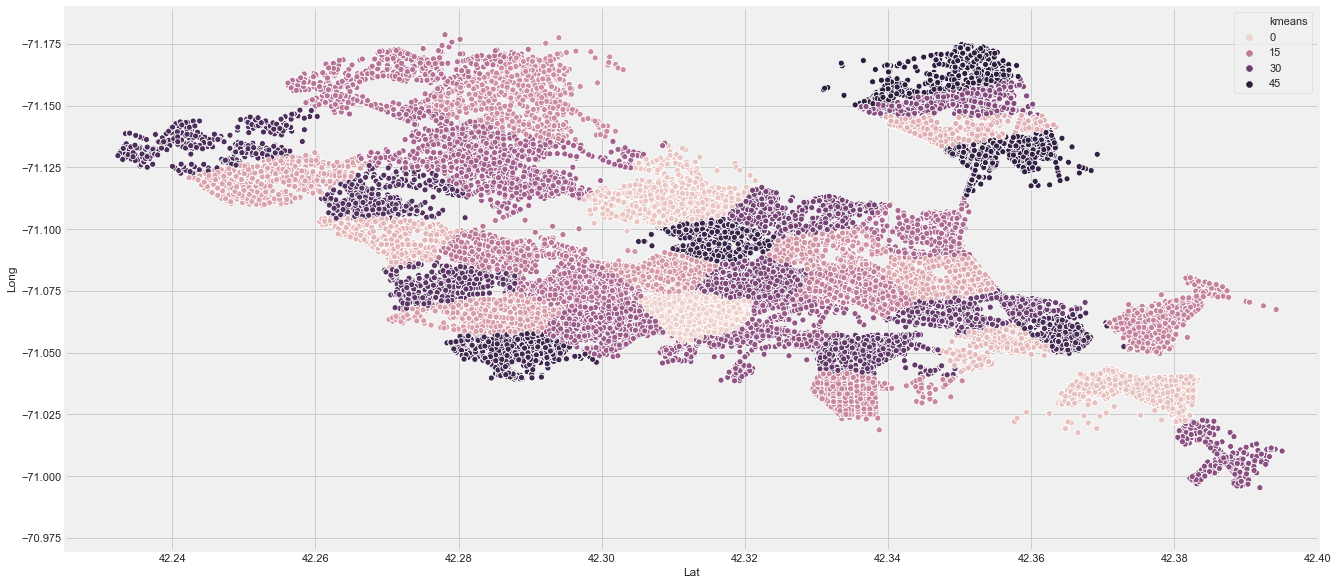

In [63]:
loc_df = loc_df.dropna()
loc_df['kmeans'] = kmeans.labels_
f,ax = plt.subplots(figsize=(20, 10))
plt.xlim((42.225,42.40))
plt.ylim((-70.97, -71.19))
sns.scatterplot(x = 'Lat', y='Long', hue = 'kmeans', data=loc_df, ax = ax)

In [120]:
a = temp_df.get_group(0)
a = a.reset_index(drop=True)
lat, long = a['Lat'][:1], a['Long'][:1]
lat = float(lat)
long = float(long)

In [122]:
dst = distance.euclidean((lat,long),tuple(centroids[0]))
dst

0.005430809409288435

In [133]:
dict(a.iloc[:1,])

{'Lat': 0    42.317319
 Name: Lat, dtype: float64,
 'Long': 0   -71.061509
 Name: Long, dtype: float64,
 'kmeans': 0    0
 Name: kmeans, dtype: int32}

In [11]:
temp_df = df['STREET'].value_counts()
temp_df = temp_df.reset_index()
temp_df.columns = ['Street', 'Count']

<BarContainer object of 10 artists>

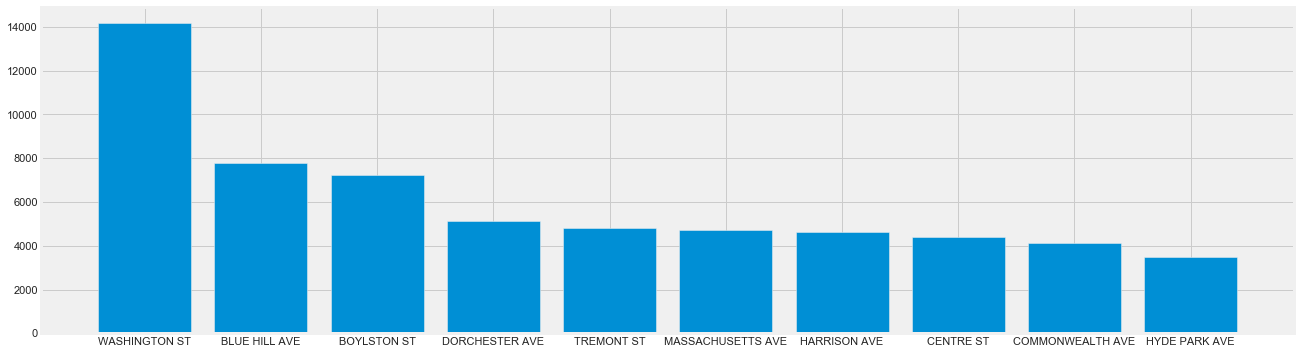

In [12]:
plt.figure(figsize=(20,6))
plt.bar(temp_df['Street'][:10],temp_df['Count'][:10])

So here we can see the 10 Streets in Boston with the highest cime frequency out which 'Washington St' show the highest frequency.
These streetss can be considered as the most unsafe places in the city.

#### Now we try to find the type of crime with highest frequuency and will try to map it with the above 10 cities. 

In [13]:
temp_df = df['OFFENSE_CODE_GROUP'].value_counts()
temp_df = temp_df.reset_index()
temp_df.columns = ['OFFENSE_GROUP', 'Count']

<BarContainer object of 10 artists>

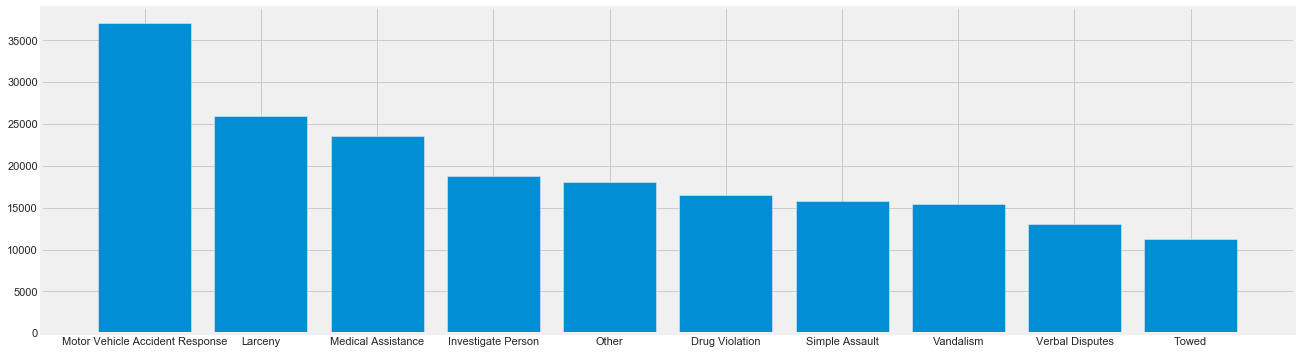

In [14]:
plt.figure(figsize=(20,6))
plt.bar(temp_df['OFFENSE_GROUP'][:10],temp_df['Count'][:10])

[42.31388096090093, -71.06571277458906]

In [17]:
temp_df = pd.DataFrame({"Date":df["DATE"].value_counts().index, "Count":df["DATE"].value_counts() })

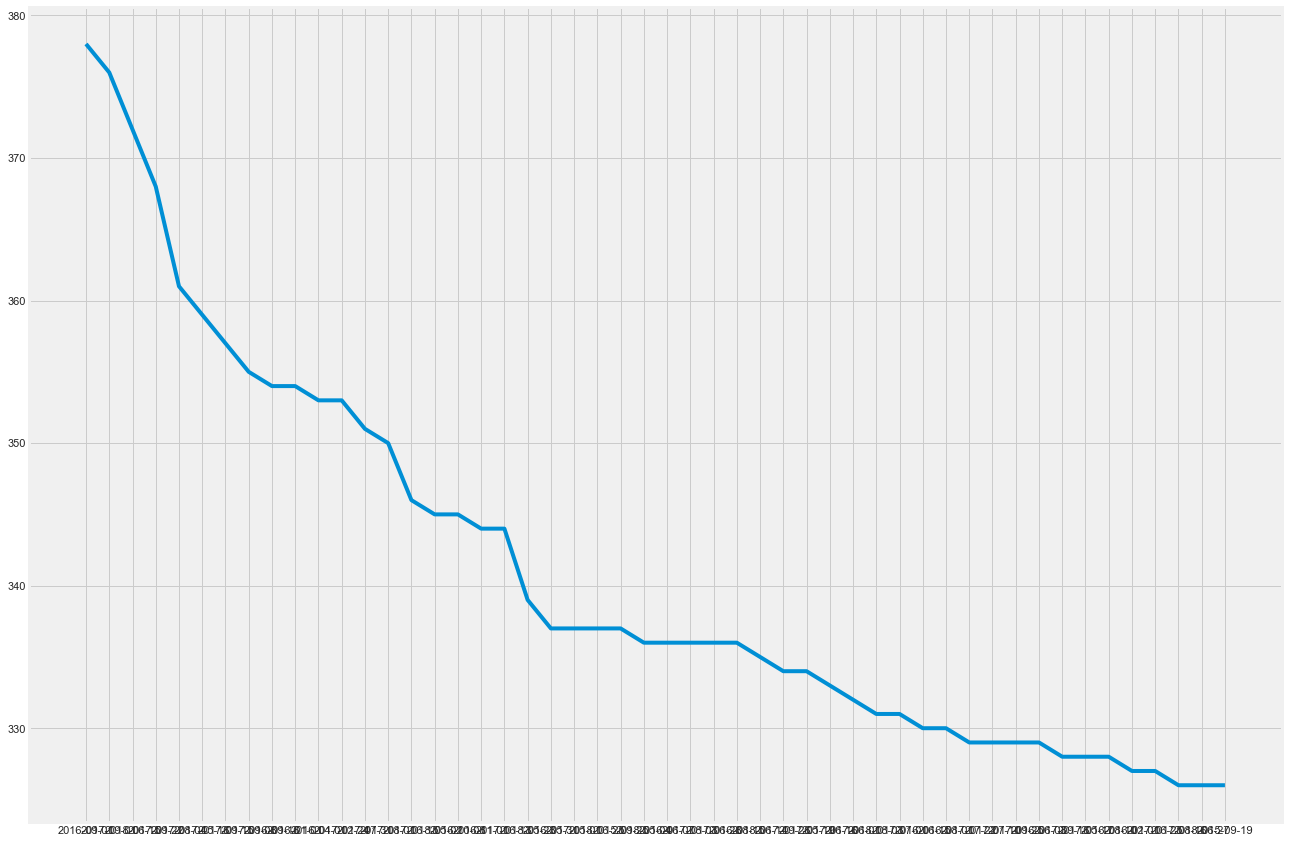

In [18]:
df.DATE.plot(kind = 'hist',bins = 50,figsize = (12,12))
plt.show()